# Generative Adversarial Networks with Keras and MNIST #

Author: Raghav Kansal

Code adapted from https://github.com/Zackory/Keras-MNIST-GAN

## Overview ##

A GAN consists of two individual networks: a discriminator and a generator. We will implement both in Keras and see how to train them to reproduce handwritten digits from the MNIST dataset. 

GANs generally work by pitting the two networks against each other. The goal of the generator is to learn the data distribution, while the goal of the discriminator is to be able to distinguish between the fake data produced by the generator and the real data from the training set. They are trained in turn: the generator takes as input random samples from a latent space and outputs fake data, its target being to fool the discriminator into classifying the fake data is real; the discriminator takes as input both real and fake data and tries to classify it correctly as real or fake. Ultimately after training them both fully the hope is that the generator is able to produce realistic looking data.

![GAN](https://cdn-media-1.freecodecamp.org/images/m41LtQVUf3uk5IOYlHLpPazxI3pWDwG8VEvU)

We can think of this as a feedback system, or as a 'minimax' two-player game. Training GANs is notoriously difficult, precisely because we need to train these two, inherently adversarial, networks simultaneously. 

### Importing and preprocessing our data ###

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras import initializers

np.random.seed(1000)


latent_dim = 10 #Our latent space will consist of 10 independent continuous variables

# normalizing MNIST data and converting image to vector
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# We'll use the Adam optimization algorithm (https://arxiv.org/pdf/1412.6980.pdf)
adam = Adam(lr=0.0002, beta_1=0.5)

Using TensorFlow backend.


### Defining our model ###

As explained in the overview, we need to define a generator network and a discriminator network. Note that ultimately both are trying to solve a 2-class classification problem (real or fake) so canonically we use the binary cross entropy as their loss function. A variant of the GAN, the Least Squares GAN, uses the mean squared error instead and can often be more effective.

The generator will take a random sample from our latent space as its input, then after four fully connected layers output a MNIST data sample:

In [2]:
generator = Sequential()
generator.add(Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

The discriminator takes a MNIST, or fake MNIST data sample after four fully connected layers outputs whether it thinks the sample is real or fake. Generally, unless their is a reason not to, we choose the generator and discriminator architectures to be mirror images.

In [ ]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3)) #dropout in the discriminator to avoid overfitting
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Finally the combined network, which feeds a random sample from the latent space into the generator and tests the output using the discriminator. As you will see below, this will only be used to train the generator, which is why we set the discriminator to not be trainable before compiling the network.

In [ ]:
# Combined network
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [3]:
#For plotting the losses for both networks at the end
def plotLoss():
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
#We'll plot a sample of the generated images after each epoch
def plotGeneratedImages(examples=10, dim=(1, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
#     plt.tight_layout()
    plt.show()

### Training ###

In each iteration we train the discriminator and generator in turn. Typically we start with the discriminator, which takes a batch of real images and a batch of fake images and is trained to classify them correctly. Then we train the generator to try to produce images which the discriminator will classify as real. 

In [5]:
def train(epochs=1, batch_size=128):
    num_batches = int(X_train.shape[0] / batch_size)
    plotGeneratedImages()

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(num_batches)):
            # Sample random noise from our latent space
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            # Sample random images from the real dataset 
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data - the correct labels are 1s for the real and 0s for fake images
            yDis = np.zeros(2*batch_size)
            yDis[:batch_size] = 0.9 # labeling as 0.9 instead of 1 is known as 'label smoothing'. 
                                    # Essentially we are penalizing the discriminator for being too sure about the real images
                                    # We are doing this here because without it the discriminator was working too well and not letting the generator improve.

            # Training discriminator. We have to tell Keras when the discriminator is or isn't being trained
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Training the generator to have the discriminator classify its produced images as real i.e. output 1s.
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            yGen = np.ones(batch_size)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        plotGeneratedImages()

    # Plot losses from every epoch
    plotLoss()

Finally, running the code:

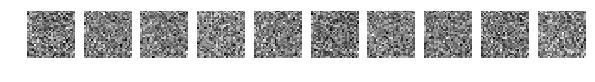

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:43<00:00, 10.86it/s]


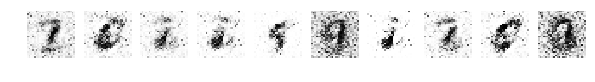

  0%|          | 2/468 [00:00<00:40, 11.46it/s]

--------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:47<00:00,  9.88it/s]


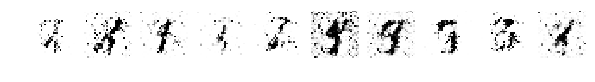

  0%|          | 2/468 [00:00<00:42, 11.05it/s]

--------------- Epoch 3 ---------------


100%|██████████| 468/468 [00:45<00:00, 10.31it/s]


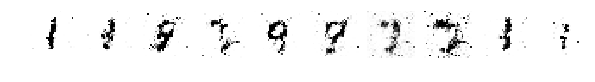

  0%|          | 2/468 [00:00<00:36, 12.86it/s]

--------------- Epoch 4 ---------------


100%|██████████| 468/468 [00:42<00:00, 11.00it/s]


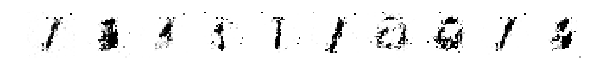

  0%|          | 2/468 [00:00<00:40, 11.56it/s]

--------------- Epoch 5 ---------------


100%|██████████| 468/468 [00:45<00:00, 10.38it/s]


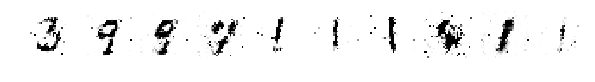

  0%|          | 2/468 [00:00<00:41, 11.19it/s]

--------------- Epoch 6 ---------------


100%|██████████| 468/468 [00:45<00:00, 10.22it/s]


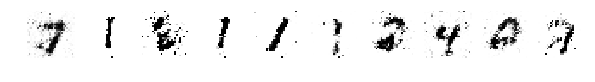

  0%|          | 1/468 [00:00<00:49,  9.47it/s]

--------------- Epoch 7 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


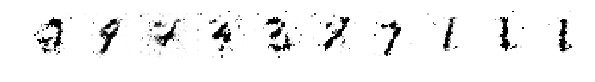

  0%|          | 2/468 [00:00<00:35, 12.95it/s]

--------------- Epoch 8 ---------------


100%|██████████| 468/468 [00:41<00:00, 11.15it/s]


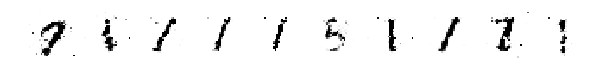

  0%|          | 2/468 [00:00<00:35, 13.12it/s]

--------------- Epoch 9 ---------------


100%|██████████| 468/468 [00:42<00:00, 11.11it/s]


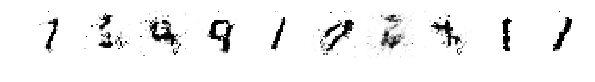

  0%|          | 2/468 [00:00<00:35, 13.21it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


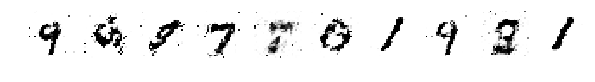

  0%|          | 2/468 [00:00<00:35, 13.13it/s]

--------------- Epoch 11 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.76it/s]


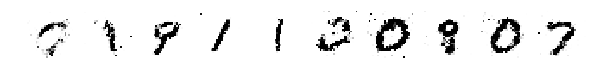

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------


100%|██████████| 468/468 [00:44<00:00, 10.43it/s]


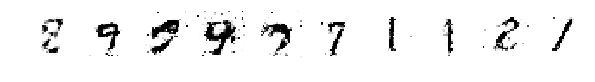

  0%|          | 2/468 [00:00<00:34, 13.46it/s]

--------------- Epoch 13 ---------------


100%|██████████| 468/468 [00:45<00:00, 10.30it/s]


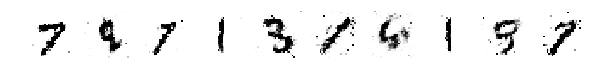

  0%|          | 2/468 [00:00<00:35, 13.10it/s]

--------------- Epoch 14 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.44it/s]


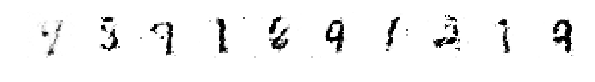

  0%|          | 2/468 [00:00<00:43, 10.72it/s]

--------------- Epoch 15 ---------------


100%|██████████| 468/468 [00:40<00:00, 11.53it/s]


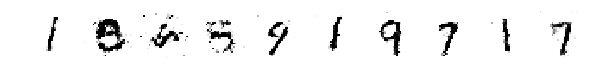

  0%|          | 2/468 [00:00<00:35, 13.06it/s]

--------------- Epoch 16 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.10it/s]


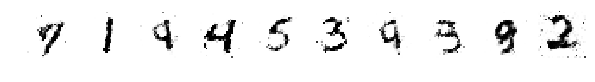

  0%|          | 2/468 [00:00<00:38, 12.00it/s]

--------------- Epoch 17 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.95it/s]


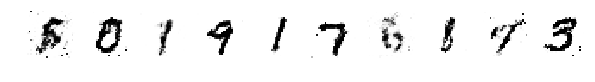

  0%|          | 2/468 [00:00<00:33, 13.99it/s]

--------------- Epoch 18 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.90it/s]


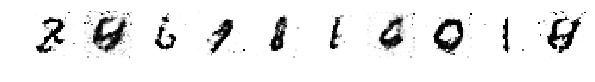

  0%|          | 2/468 [00:00<00:33, 14.08it/s]

--------------- Epoch 19 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.82it/s]


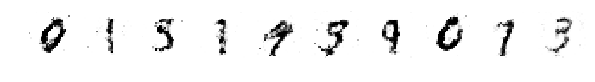

  0%|          | 2/468 [00:00<00:32, 14.42it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.72it/s]


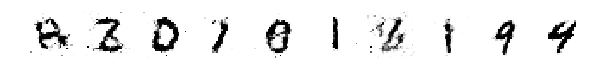

  0%|          | 2/468 [00:00<00:33, 14.04it/s]

--------------- Epoch 21 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.55it/s]


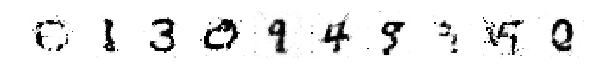

  0%|          | 2/468 [00:00<00:32, 14.27it/s]

--------------- Epoch 22 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.44it/s]


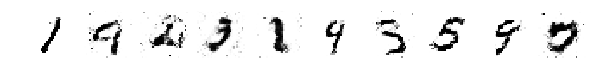

  0%|          | 2/468 [00:00<00:33, 14.05it/s]

--------------- Epoch 23 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.49it/s]


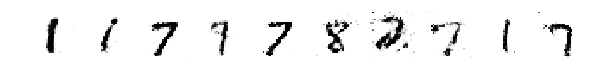

  0%|          | 2/468 [00:00<00:33, 14.06it/s]

--------------- Epoch 24 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.77it/s]


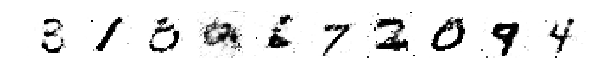

  0%|          | 2/468 [00:00<00:32, 14.47it/s]

--------------- Epoch 25 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.36it/s]


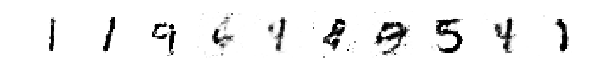

  0%|          | 2/468 [00:00<00:32, 14.17it/s]

--------------- Epoch 26 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.75it/s]


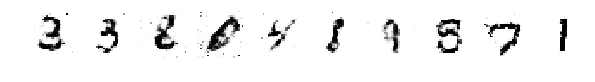

  0%|          | 2/468 [00:00<00:33, 13.94it/s]

--------------- Epoch 27 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.53it/s]


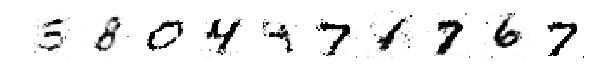

  0%|          | 2/468 [00:00<00:33, 14.01it/s]

--------------- Epoch 28 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.62it/s]


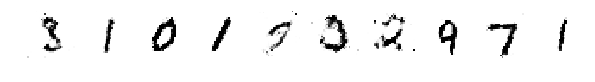

  0%|          | 2/468 [00:00<00:32, 14.40it/s]

--------------- Epoch 29 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.53it/s]


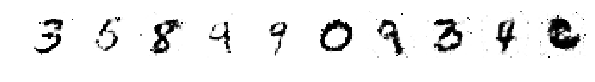

  0%|          | 2/468 [00:00<00:32, 14.40it/s]

--------------- Epoch 30 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.51it/s]


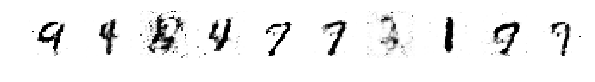

  0%|          | 2/468 [00:00<00:34, 13.61it/s]

--------------- Epoch 31 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.60it/s]


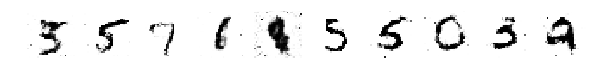

  0%|          | 2/468 [00:00<00:33, 13.99it/s]

--------------- Epoch 32 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.29it/s]


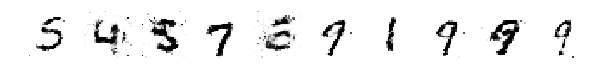

  0%|          | 2/468 [00:00<00:31, 14.62it/s]

--------------- Epoch 33 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.48it/s]


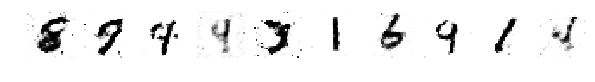

  0%|          | 2/468 [00:00<00:33, 14.03it/s]

--------------- Epoch 34 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.31it/s]


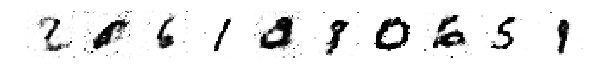

  0%|          | 2/468 [00:00<00:32, 14.31it/s]

--------------- Epoch 35 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.50it/s]


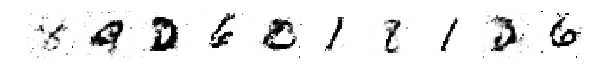

  0%|          | 2/468 [00:00<00:33, 14.10it/s]

--------------- Epoch 36 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.91it/s]


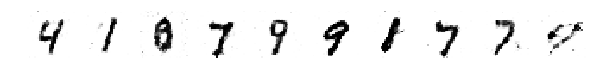

  0%|          | 2/468 [00:00<00:35, 13.24it/s]

--------------- Epoch 37 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.55it/s]


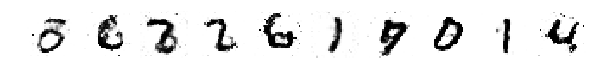

  0%|          | 2/468 [00:00<00:35, 12.97it/s]

--------------- Epoch 38 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.72it/s]


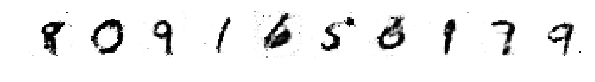

  0%|          | 2/468 [00:00<00:33, 13.86it/s]

--------------- Epoch 39 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.58it/s]


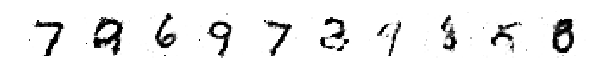

  0%|          | 2/468 [00:00<00:34, 13.39it/s]

--------------- Epoch 40 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.55it/s]


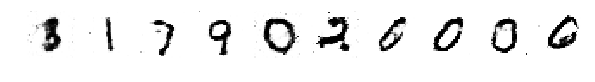

  0%|          | 2/468 [00:00<00:35, 13.15it/s]

--------------- Epoch 41 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.34it/s]


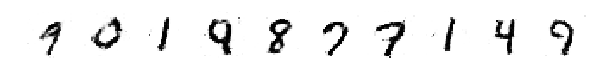

  0%|          | 2/468 [00:00<00:33, 13.83it/s]

--------------- Epoch 42 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.65it/s]


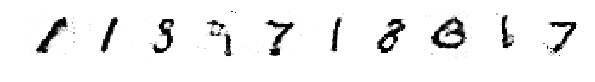

  0%|          | 2/468 [00:00<00:34, 13.66it/s]

--------------- Epoch 43 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.22it/s]


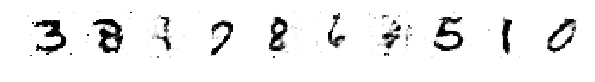

  0%|          | 2/468 [00:00<00:34, 13.62it/s]

--------------- Epoch 44 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.67it/s]


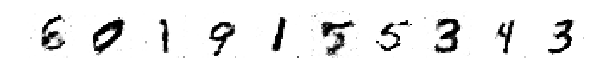

  0%|          | 2/468 [00:00<00:32, 14.44it/s]

--------------- Epoch 45 ---------------


100%|██████████| 468/468 [02:31<00:00,  3.08it/s]


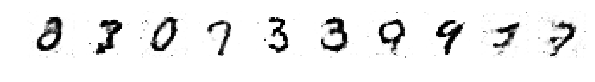

  0%|          | 2/468 [00:00<00:40, 11.52it/s]

--------------- Epoch 46 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.45it/s]


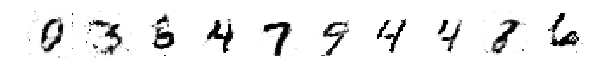

  0%|          | 2/468 [00:00<00:30, 15.19it/s]

--------------- Epoch 47 ---------------


100%|██████████| 468/468 [00:34<00:00, 13.44it/s]


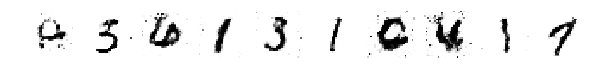

  0%|          | 2/468 [00:00<00:32, 14.31it/s]

--------------- Epoch 48 ---------------


100%|██████████| 468/468 [00:36<00:00, 12.68it/s]


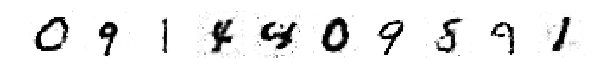

  0%|          | 2/468 [00:00<00:34, 13.38it/s]

--------------- Epoch 49 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.18it/s]


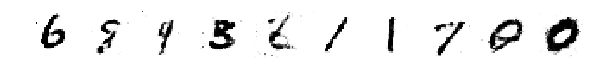

  0%|          | 2/468 [00:00<00:31, 14.59it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.78it/s]


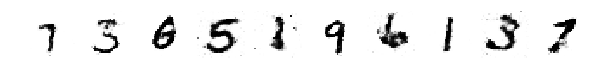

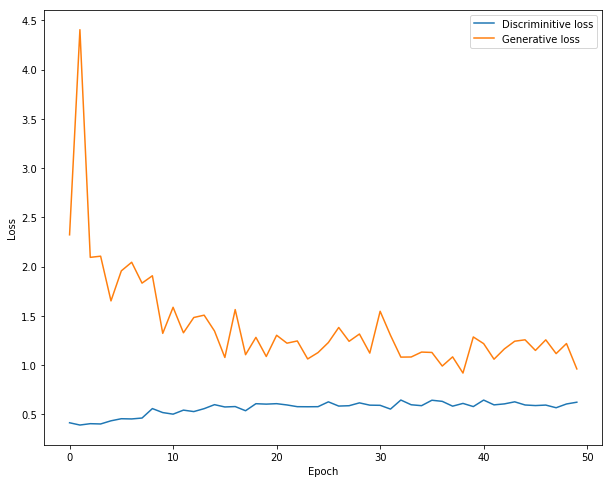

In [6]:
dLosses = []
gLosses = []

train(50, 128)